In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers



/Users/user/repos/tbilisi_home_price_prediction_model/pricing_model/env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%matplotlib inline


In [3]:
path_to_csv = "../data/housing_data.csv"
image_dir = "../data/images" 
column_names = ["id", "url", "imageurl", "header", "price", "sqmprice", "sqm", "floor", "rooms", "bedrooms", "address"]


In [4]:
df = pd.read_csv(path_to_csv, names=column_names, header=None)
image_files = set(os.listdir(image_dir))
valid_ids = {int(filename.split('.')[0]) for filename in image_files if filename.split('.')[0].isdigit()}
df = df[df.iloc[:, 0].isin(valid_ids)]
df = df.dropna() # We lost 5% of the data, problem seems to be with the method of scraping or the website error itself
df.drop(['url', 'imageurl'], axis=1, inplace=True)

In [5]:
df['status'] = df['header'].str.split().str.get(1)
df['location_name'] = df['header'].str.replace("იყიდება ახალი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება ძველი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება მშენებარე ბინა ", "", regex=False).str.strip()

value_counts = df['location_name'].value_counts()
print(value_counts)
# Keep only rows where the 'location_name' value count is >= 30
df = df[df['location_name'].isin(value_counts[value_counts >= 30].index)]
df.drop(['header', 'address'], axis=1, inplace=True)


location_name
საბურთალოზე        8473
ვაკეში             3615
დიდ დიღომში        2509
დიდუბეში           1853
გლდანის მასივში    1730
                   ... 
ბეთანიაში             1
ვარდისუბანში          1
ლოტკინზე              1
წავკისში              1
მადათოვზე             1
Name: count, Length: 126, dtype: int64


In [6]:
df["price"] = df["price"].str.replace(",", "").astype(float)
df["sqm"] = df["sqm"].str.replace(" მ²", "").astype(float)
df["floor"] = df["floor"].str.replace("სარ.", "").astype(float)
df["rooms"] = df["rooms"].str.replace("ოთ.", "").astype(float)
df["bedrooms"] = df["bedrooms"].str.replace("საძ.", "").astype(float)
df.drop("sqmprice", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)



In [7]:
df.sort_values(by='price', ascending=True)

,price,sqm,floor,rooms,bedrooms,status,location_name
12625,12800.0,44.9,12.0,2.0,1.0,მშენებარე,დიდ დიღომში
22055,13000.0,13.0,1.0,1.0,1.0,ახალი,ვაჟა-ფშაველას კვარტალებში
40403,14000.0,34.0,1.0,3.0,1.0,ახალი,გლდანი 1 მკრ. რაიონში
16714,15000.0,8.9,1.0,1.0,1.0,ძველი,სოლოლაკში
20427,15000.0,74.0,3.0,1.0,1.0,ძველი,ჩუღურეთის რაიონში
...,...,...,...,...,...,...,...
16671,13950000.0,90.0,1.0,3.0,2.0,ახალი,საბურთალოზე
3467,16200000.0,108.0,2.0,3.0,2.0,ახალი,საბურთალოზე
18797,32400000.0,120.0,4.0,3.0,2.0,ახალი,ვაკეში
15287,100000000.0,251.0,2.0,7.0,5.0,ძველი,ვერაზე


In [8]:
df = df[df["price"] <= 500000]
df = df[df["price"] >= 10000]


In [9]:
scaler = MinMaxScaler()
price_scaler = MinMaxScaler()
df[['sqm', 'floor', 'rooms', 'bedrooms']] = scaler.fit_transform(df[['sqm', 'floor', 'rooms', 'bedrooms']])
df[['price']] = price_scaler.fit_transform(df[['price']])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['location_name', "status"])

bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)
# Split the data into training and test sets
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Model definition

model = Sequential([
    layers.Dense(512, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1],),),
    layers.BatchNormalization(),

    layers.Dense(256, activation='relu', kernel_initializer='he_normal',  ),
    layers.BatchNormalization(),
    
    layers.Dense(128, activation='relu', kernel_initializer='he_normal',  ),
    layers.BatchNormalization(),
    
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', ),
    layers.BatchNormalization(),
    
    layers.Dense(32, activation='relu', kernel_initializer='he_normal',  ),
    
    layers.Dense(1)
    ]
)



In [11]:
model.compile(optimizer=keras.optimizers.legacy.Adam(0.001), loss='mean_squared_error',  metrics=['mean_absolute_error'])

In [12]:
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
802/802 [==============================] - 4s 4ms/step - loss: 0.0678 - mean_absolute_error: 0.1684 - val_loss: 0.0178 - val_mean_absolute_error: 0.0964
Epoch 2/150
802/802 [==============================] - 3s 3ms/step - loss: 0.0171 - mean_absolute_error: 0.0965 - val_loss: 0.0124 - val_mean_absolute_error: 0.0814
Epoch 3/150
802/802 [==============================] - 3s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0830 - val_loss: 0.0117 - val_mean_absolute_error: 0.0744
Epoch 4/150
802/802 [==============================] - 2s 3ms/step - loss: 0.0119 - mean_absolute_error: 0.0774 - val_loss: 0.0110 - val_mean_absolute_error: 0.0727
Epoch 5/150
802/802 [==============================] - 2s 3ms/step - loss: 0.0107 - mean_absolute_error: 0.0725 - val_loss: 0.0133 - val_mean_absolute_error: 0.0798
Epoch 6/150
802/802 [==============================] - 2s 3ms/step - loss: 0.0100 - mean_absolute_error: 0.0690 - val_loss: 0.0081 - val_mean_absolute_error: 0.0612
Epoch 7/15

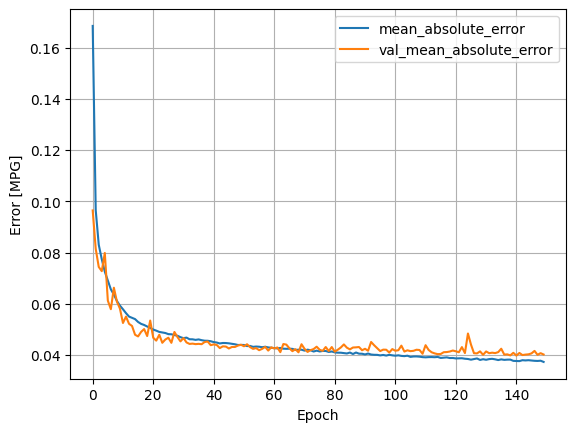

In [13]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
def plot_mae(history):
  plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
  plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)  
#plot_loss(history)
plot_mae(history)

In [14]:
loss, mae = model.evaluate(X_test, y_test)
train_loss, train_mae = model.evaluate(X_train, y_train)

print(f"Test Loss: {loss}")
scaled_mae = mae
scaled_train_mae = train_mae
original_mae = scaled_mae * (price_scaler.data_max_ - price_scaler.data_min_)
original_train_mae = scaled_train_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original MAE: {original_mae[0]}")
print(f"Original train MAE: {original_train_mae[0]}")

1002/1002 [==============================] - 1s 977us/step - loss: 0.0037 - mean_absolute_error: 0.0365
Test Loss: 0.0046573239378631115
Original MAE: 19768.912035226822
Original train MAE: 17770.790138840675


In [15]:
# 1. Predict on test data
y_pred = model.predict(X_train)

# Inverse transform the scaled target variable (y_test)
y_test_actual = price_scaler.inverse_transform(y_train.values.reshape(-1, 1))

# Inverse transform the scaled predictions (y_pred)
y_pred_actual = price_scaler.inverse_transform(y_pred.reshape(-1, 1))

print(y_test_actual.shape)
print(y_pred_actual.shape)

# 2. Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Values': y_test_actual.flatten(),
    'Predicted Values': y_pred_actual.flatten() # flatten is used to convert the 2D array to 1D
})

print(comparison_df)


1002/1002 [==============================] - 1s 959us/step
(32061, 1)
(32061, 1)
       Actual Values  Predicted Values
0            74900.0      74691.859375
1           320000.0     292275.437500
2           147300.0     190058.984375
3           261100.0     274671.062500
4           150000.0     148765.484375
...              ...               ...
32056        95000.0      78543.781250
32057       115000.0     114359.335938
32058       150000.0     151125.703125
32059       135000.0     126494.406250
32060        95000.0     101926.468750

[32061 rows x 2 columns]


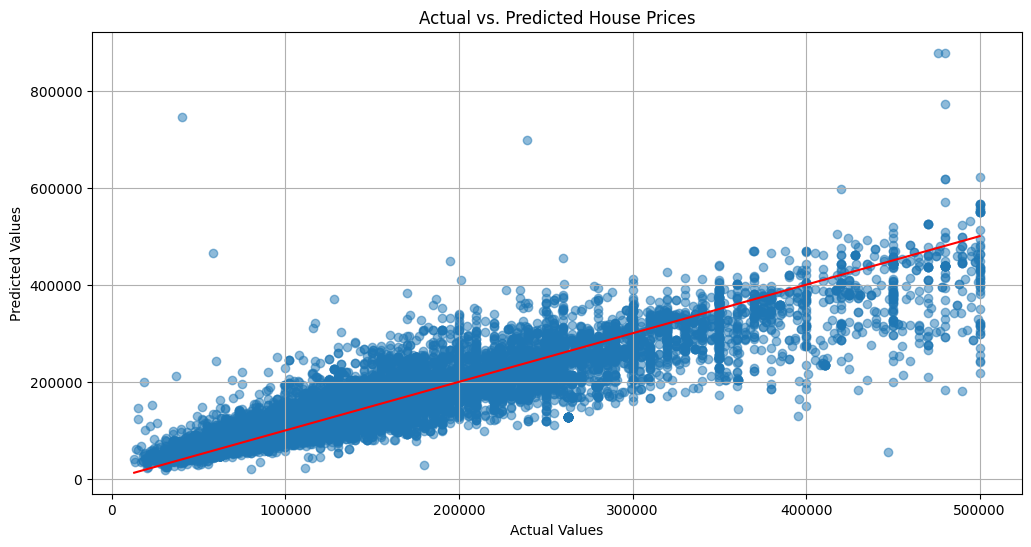

In [16]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(comparison_df['Actual Values'], comparison_df['Predicted Values'], alpha=0.5)
plt.plot([min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         [min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         color='red')  # Diagonal line

plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [17]:
y_pred_test = model.predict(X_test)
y_test_actual_for_r2 = price_scaler.inverse_transform(y_test.values.reshape(-1, 1))
y_pred_actual_for_r2 = price_scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Calculate the R^2 score
r2 = r2_score(y_test_actual_for_r2, y_pred_actual_for_r2)
r2

251/251 [==============================] - 0s 1ms/step


0.8234928373735882